In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pyccl as ccl

import sys
sys.path.append('../cluster_abundance/')
import CL_COUNT_DATAOPS_cluster_abundance_covariance as covariance
import CL_COUNT_class_cluster_abundance as cl_count
import CL_COUNT_class_likelihood as lnL

%load_ext autoreload
%autoreload 2

%matplotlib inline

# Extract DM haloes from the SkySim catalog in a given mass and redshift range. 

In [2]:
zmin = 0.
zmax = 1.

## Use the pre-extracted halo catalog stored at CC-IN2P3 or NERSC
You may skip the step above by directly using pre-extracted SkySim halo catalog. These are stored as `hdf5` at CC-IN2P3 and NERSC. These files contains all DM halos of SkySim5000 with $M_{\rm fof}>1\times 10^{13}$M$_\odot$ and $z\in[0,1.2]$. Richness information (not used here) is also available in those files, along with some other halo-related columns. SkySim input cosmology and sky area are also saved as metadata in the file.

You may choose among:
- `skysim_halos_z=0-1.2_mfof_gt_1e13_small.hdf5` for the `small` sky area (~57 deg2)
- `skysim_halos_z=0-1.2_mfof_gt_1e13_image.hdf5` for the `image` sky area (~440 deg2)
- `skysim_halos_z=0-1.2_mfof_gt_1e13_full.hdf5` for the `full` sky area (~5200 deg2)

**Path to access the files at CC-IN2P3:**
`/sps/lsst/users/ccombet/SkySim5000/hdf5`

**Path to access the files at NERSC:**
`/global/u1/c/ccombet/SkySim5000/hdf5`

Comment/uncomment accordingly in the cell below

In [3]:
import pandas as pd

path_to_cat = '/sps/lsst/users/ccombet/SkySim5000/hdf5' # CC-in2p3
# path_to_cat = '/global/u1/c/ccombet/SkySim5000/hdf5' # NERSC

size = 'image' # other options are 'image' (440 deg2) and 'small' (57 deg2)

with pd.HDFStore(os.path.join(path_to_cat,f'skysim_halos_z=0-1.20_mfof_gt_1.00e+13_{size}.hdf5')) as store:
    dm_halos = store['skysim']
    metadata = store.get_storer('skysim').attrs.metadata

cosmo_ss  = metadata['cosmo']
sky_area = metadata['sky_area']
N_cl = len(dm_halos['halo_mass'])
print(f'There are {N_cl} halos with Mfof > 1e13 Msun and z=[0,1.2] in {sky_area} deg2')

There are 249485 halos with Mfof > 1e13 Msun and z=[0,1.2] in 439.78986 deg2


## Filter on redshift and mass ranges

**Caution**: if using the pre-extracted halo catalog, make sure you do not require here mass and redshift ranges larger than the ones specified above.

NB: SkySim5000 M200c masses are in units of Msun/h

In [4]:
zmin = 0.25
zmax = 1.
mmin = 5.e13 # Msun. 
mmax = 1.e15 # Msun

16582 left in the [5.00e+13,1.00e+15[ mass range and [0.25,1.00[ redshift range


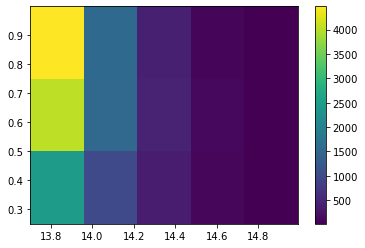

In [5]:
dm_halos['M200c'] = dm_halos['baseDC2/sod_halo_mass']/cosmo_ss.h # sod_halo_mass = M200,c in Msun/h, needs conversion

filt1 = dm_halos['redshift'] >= zmin
filt2 = dm_halos['redshift'] < zmax
filt3 = dm_halos['M200c'] >= mmin 
filt4 = dm_halos['M200c'] < mmax
filt = filt1 & filt2 & filt3 & filt4

data_m_ss = np.array(dm_halos['M200c'][filt]) # M200,c [Msun]
data_z_ss = np.array(dm_halos['redshift'][filt])

print(f"{len(data_m_ss)} left in the [{mmin:.2e},{mmax:.2e}[ mass range and [{zmin:.2f},{zmax:.2f}[ redshift range")
hist2d = plt.hist2d(np.log10(data_m_ss), data_z_ss, bins=[5,3]);
plt.colorbar()

In [6]:
count = hist2d[0]
logm_edges = hist2d[1]
z_edges = hist2d[2]

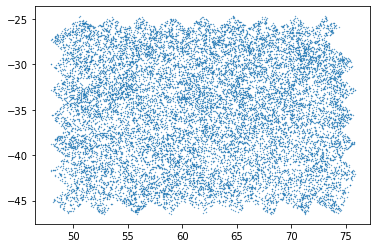

In [7]:
plt.scatter(dm_halos['ra'][filt],dm_halos['dec'][filt], s=0.1)

# Measure count covariance matrix

In [8]:
Covariance = covariance.Covariance_matrix()

In [ ]:
hp_res = 8
cov_jk = Covariance.compute_jackknife_covariance_healpy(catalog = dm_halos, proxy_colname = 'M200c', 
                                           redshift_colname = 'redshift', z_corner = z_edges, 
                                           proxy_corner = 10**logm_edges, ra_colname = 'ra', 
                                           dec_colname = 'dec', n_power = hp_res, N_delete = 1)

In [10]:
cov_bs = Covariance.compute_boostrap_covariance(catalog = dm_halos, proxy_colname = 'M200c', 
                                    redshift_colname = 'redshift', proxy_corner = 10**logm_edges, 
                                    z_corner = z_edges, n_boot = 300)

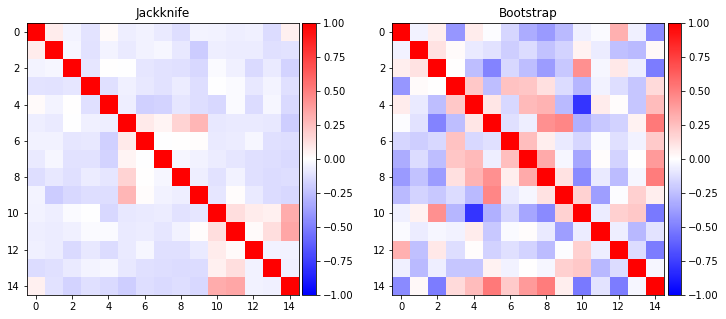

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
im0 = axes[0].imshow(np.corrcoef(Covariance.Jackknife_covariance_matrix), vmin=-1, vmax=1, cmap='bwr')
im1 = axes[1].imshow(np.corrcoef(Covariance.Bootstrap_covariance_matrix), vmin=-1, vmax=1, cmap='bwr')
axes[0].set_title('Jackknife')
axes[1].set_title('Bootstrap')
divider = make_axes_locatable(axes[0])
cax0 = divider.append_axes('right', size='5%', pad=0.05)
divider = make_axes_locatable(axes[1])
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax0, orientation='vertical')
fig.colorbar(im1, cax=cax1, orientation='vertical')

# Predict model from true cosmology

In [12]:
# Grid for HMF evaluation
z_grid = np.linspace(zmin, zmax, 500)
logm_grid = np.linspace(np.log10(mmin),np.log10(mmax), 500)

# Check likelihood with the right comsology
cosmo = ccl.Cosmology(Omega_c = cosmo_ss.Om0 - cosmo_ss.Ob0, Omega_b = cosmo_ss.Ob0, 
                      h = cosmo_ss.h, sigma8 = cosmo_ss.sigma8, n_s=cosmo_ss.n_s)

massdef = ccl.halos.MassDef(200, 'critical')
hmd = ccl.halos.MassFuncTinker08(cosmo, mass_def=massdef)

clc = cl_count.ClusterAbundance()
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = sky_area*(np.pi/180.)*(np.pi/180.)

In [13]:
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
count_prediction = clc.Cluster_Abundance_MZ(zbin_edges = z_edges, proxybin_edges = logm_edges, method = 'grid')

## Residuals 

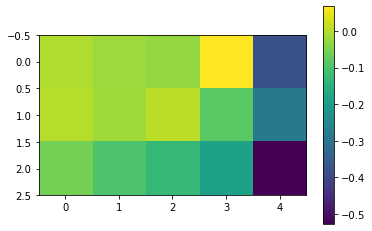

In [14]:
plt.imshow((count_prediction-count.T)/count.T)
plt.colorbar()

# Binned Gaussian Likelihood

In [15]:
Likelihood = lnL.Likelihood()

In [16]:
lnL_Binned_Gaussian = Likelihood.lnLikelihood_Binned_Gaussian(count_prediction, count.T, 
                                                              Covariance.Jackknife_covariance_matrix)
print(Likelihood.lnL_Binned_Gaussian)

-21.25730540492676


# Likelihood Maximization to get ($\sigma_8, \Omega_m$) (using `Minuit`) 

In [17]:
clc = cl_count.ClusterAbundance()
clc.sky_area = sky_area*(np.pi/180.)*(np.pi/180.)
Likelihood = lnL.Likelihood()

def m_log_likelihood(sigma8, Omega_m):
    cosmo = ccl.Cosmology(Omega_c = Omega_m - cosmo_ss.Ob0, Omega_b = cosmo_ss.Ob0, 
                      h = cosmo_ss.h, sigma8 = sigma8, n_s=cosmo_ss.n_s, T_CMB=2.725)
    
    hmd = ccl.halos.MassFuncTinker08(cosmo, mass_def=massdef)
    clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
    
    if ltype == 'BG' or ltype == 'BP':
        clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
        abundance_predict = clc.Cluster_Abundance_MZ(zbin_edges = z_edges, 
                                                     proxybin_edges = logm_edges, 
                                                     method=method)

    if ltype == 'BG':
        Likelihood.lnLikelihood_Binned_Gaussian(abundance_predict, count.T, Covariance.Jackknife_covariance_matrix)
        return -Likelihood.lnL_Binned_Gaussian
    if ltype == 'BP':
        Likelihood.lnLikelihood_Binned_Poissonian(abundance_predict, count.T)
        return -Likelihood.lnL_Binned_Poissonian


In [18]:
from iminuit import Minuit

ltype='BG' 
method='grid'
z_grid = np.linspace(zmin, zmax, 500)
logm_grid = np.linspace(np.log10(mmin),np.log10(mmax), 500)

m1 = Minuit(m_log_likelihood, 0.8, 0.3)
m1.limits['sigma8'] = [0.7,0.9]
m1.limits['Omega_m'] = [0.2,0.4]
m1.errordef = 0.5 # because dealing with likelihood function
m1.migrad() # finds minimum 
m1.hesse() # computes errors 

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.861                      │              Nfcn = 112              │
│ EDM = 0.000432 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ sigma8  │   0.822   │   0.005   │            │            │   0.7   │   0.9   │       │
│ 1 │ Omega_m │   0.253   │   0.004   │            │            │   0.2   │   0.4   │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────────────────┐
│         │    sigma8   Omega_m │
├─────────┼─────────────────────┤
│  sigma8 │  2.59e-05 -1.82e-05 │
│ Omega_m │ -1.82e-05  1.47e-05 │
└─────────┴─────────────────────┘

In [19]:
ltype='BP' 

m2 = Minuit(m_log_likelihood, 0.8, 0.3)
m2.limits['sigma8'] = [0.7,0.9]
m2.limits['Omega_m'] = [0.2,0.4]
m2.errordef = 0.5 # because dealing with likelihood function
m2.migrad() # finds minimum 
m2.hesse()  # computes errors 

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.118e+05                 │              Nfcn = 65               │
│ EDM = 8.03e-07 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ sigma8  │   0.824   │   0.005   │            │            │   0.7   │   0.9   │       │
│ 1 │ Omega_m │   0.252   │   0.004   │            │            │   0.2   │   0.4   │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────┐
│         │   sigma8  Omega_m │
├─────────┼───────────────────┤
│  sigma8 │ 2.38e-05 -1.7e-05 │
│ Omega_m │ -1.7e-05 1.36e-05 │
└─────────┴───────────────────┘

In [20]:
from matplotlib.patches import Ellipse

def _make_ellipse(mean, cov, ax, color=None, label = None, ls = '-',):
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi 
    for i in [3]:
        ell = Ellipse(mean, 2 * i * v[0] ** 0.5, 2 * i * v[1] ** 0.5,
                                  180 + angle,
                                  linewidth=2, facecolor = 'none',edgecolor=color, ls = ls)
        ax.add_patch(ell)
#    ax.plot([],[],ls, color = color, label = label)

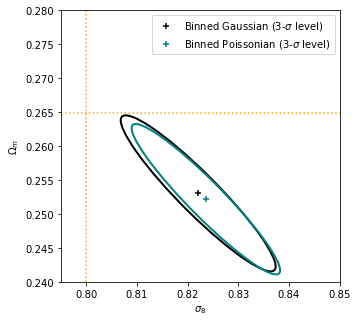

In [21]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
_make_ellipse(m1.values, m1.covariance, ax1, color='black', ls = '-')
_make_ellipse(m2.values, m2.covariance, ax1, color='teal', ls = '-')
ax1.set_ylim([0.24,0.28])
ax1.set_xlim([0.795,0.85])
ax1.axvline(cosmo_ss.sigma8, color='orange', ls=':')
ax1.axhline(cosmo_ss.Om0, color='orange', ls=':')
ax1.scatter(m1.values['sigma8'],m1.values['Omega_m'], color='black', marker='+', label='Binned Gaussian (3-$\sigma$ level)')
ax1.scatter(m2.values['sigma8'],m2.values['Omega_m'], color='teal', marker='+', label='Binned Poissonian (3-$\sigma$ level)')
ax1.set_xlabel('$\sigma_8$')
ax1.set_ylabel('$\Omega_m$')
ax1.legend()

fig.savefig(f'contours_{size}_{mmin:.2e}_{mmax:.2e}_{hp_res}.png')